In [3]:
"""
    TensorFlow training code for
    "Data-Integrated Semi-Supervised Attention Enhances Performance 
    and Interpretability of Biological Classification Tasks"
    
    This file includes:
     * cancer classification training code which DSSA
     * visualization of saliency map

    2025 Jun Kim
"""
import pickle
import random
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Input, LeakyReLU, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [4]:
with open('datasets/TCGA_new_pre_second.pckl', 'rb') as file_second:
    (dropped_genes_final, dropped_gene_name, dropped_Ens_id, samp_id_new, diag_name_new, project_ids_new) = pd.compat.pickle_compat.load(file_second)
with open('datasets/TCGA_new_pre_first.pckl', 'rb') as file_first:
    _, _, _, _, remain_cancer_ids_ind, remain_normal_ids_ind = pickle.load(file_first)

In [5]:
# Integer Encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(project_ids_new)
# One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded_reshaped = integer_encoded.reshape(-1, 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded_reshaped)
# Cancer sample prep
X_cancer_samples = dropped_genes_final.iloc[:, remain_cancer_ids_ind].T.values
onehot_encoded_cancer_samples = onehot_encoded[remain_cancer_ids_ind]
X_cancer_samples_mat = np.concatenate(
    (X_cancer_samples, np.zeros((X_cancer_samples.shape[0], 9))),
    axis=1
)

# Reshape to (num_samples, 71, 100)
X_cancer_samples_mat = X_cancer_samples_mat.reshape(-1, 71, 100)

# Split into train and test sets
num_samples = X_cancer_samples_mat.shape[0]
all_indices = np.arange(num_samples)
y_labels = integer_encoded[remain_cancer_ids_ind]
x_train, x_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_cancer_samples_mat,
    onehot_encoded_cancer_samples,
    all_indices,
    stratify=y_labels, 
    test_size=0.25,
    random_state=42
)

# Parameters
img_rows, img_cols = x_test.shape[1], x_test.shape[2]
num_classes = y_train.shape[1]
batch_size = 128

# Reshape data
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).astype('float32')

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128)

In [61]:
def small_convolutional_model():
    model = Sequential()
    model.add(
        Conv2D(
            filters=1,
            kernel_size= (1, 17),
            strides=(1, 1),
            input_shape=(img_rows, img_cols, 1) 
        )
    )
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Flatten())
    model.add(Dense(33, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [7]:
# This code identifies overexpressed genes for each cancer type
gene_expression = dropped_genes_final.iloc[:, remain_cancer_ids_ind].T  
gene_expression.index = samp_id_new[remain_cancer_ids_ind]

labels = pd.Series(project_ids_new[remain_cancer_ids_ind], index=gene_expression.index)
label_names = pd.Series(diag_name_new[remain_cancer_ids_ind], index=gene_expression.index)

# Get cancer types
cancer_types = labels.unique()
print(f"Detected cancer types: {cancer_types}")

# Store overexpressed genes for each cancer type
overexpressed_genes = {}

# Differential Expression Analysis

for cancer in cancer_types:
    print(f"\nAnalyzing cancer type: {cancer} ({label_names[labels == cancer].iloc[0]})")

    # 1 for current cancer type, 0 for others
    binary_labels = (labels == cancer).astype(int)

    # Split the data
    expr_cancer = gene_expression[binary_labels == 1]
    expr_other = gene_expression[binary_labels == 0]
    print(f"Number of samples in {cancer}: {expr_cancer.shape[0]}")
    print(f"Number of samples in other cancers: {expr_other.shape[0]}")

    # Compute p-value and fold change
    p_values = []
    fold_changes = []

    for gene in gene_expression.columns:
        expr1 = expr_cancer[gene]
        expr2 = expr_other[gene]

        t_stat, p_val = ttest_ind(expr1, expr2, equal_var=False)  # Welch's t-test
        p_values.append(p_val)

        mean_cancer = expr1.mean()
        mean_other = expr2.mean()
        # A small value (e.g., 1e-9) added to avoid division by 0
        fold_change = np.log2((mean_cancer + 1e-9) / (mean_other + 1e-9))
        fold_changes.append(fold_change)
    
    # Benjamini-Hochberg FDR
    p_values = np.array(p_values)
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'Gene': gene_expression.columns,
        'FoldChange': fold_changes,
        'PValue': p_values,
        'AdjustedPValue': pvals_corrected,
        'Significant': reject
    })
    # FoldChange > 1 (i.e., log2FC > 1 => FC > 2) and significant
    overexpressed = results[(results['FoldChange'] > 1) & (results['Significant'])]
    # Sorted by p-value
    overexpressed = overexpressed.sort_values('AdjustedPValue')
    top_n = 100
    overexpressed_genes[cancer] = overexpressed.head(top_n)
    print(f"Number of overexpressed genes in {cancer}: {overexpressed.shape[0]}")
    print(overexpressed[['Gene', 'FoldChange', 'AdjustedPValue']].head())

Detected cancer types: ['TCGA-ACC' 'TCGA-BLCA' 'TCGA-BRCA' 'TCGA-CESC' 'TCGA-CHOL' 'TCGA-COAD'
 'TCGA-DLBC' 'TCGA-ESCA' 'TCGA-GBM' 'TCGA-HNSC' 'TCGA-KICH' 'TCGA-KIRC'
 'TCGA-KIRP' 'TCGA-LGG' 'TCGA-LIHC' 'TCGA-LUAD' 'TCGA-LUSC' 'TCGA-MESO'
 'TCGA-OV' 'TCGA-PAAD' 'TCGA-PCPG' 'TCGA-PRAD' 'TCGA-READ' 'TCGA-SARC'
 'TCGA-SKCM' 'TCGA-STAD' 'TCGA-TGCT' 'TCGA-THCA' 'TCGA-THYM' 'TCGA-UCEC'
 'TCGA-UCS' 'TCGA-UVM' 'TCGA-LAML']

Analyzing cancer type: TCGA-ACC (Adrenocortical Carcinoma)
Number of samples in TCGA-ACC: 79
Number of samples in other cancers: 10261
Number of overexpressed genes in TCGA-ACC: 203
       Gene  FoldChange  AdjustedPValue
2917   7965    4.108827    7.408171e-49
5514  16712    2.427432    3.689570e-47
2737   7470    3.793186    4.874490e-47
3797  10602    1.367244    1.636446e-44
4916  14171    2.179869    5.001259e-43

Analyzing cancer type: TCGA-BLCA (Bladder Urothelial Carcinoma)
Number of samples in TCGA-BLCA: 414
Number of samples in other cancers: 9926
Number of overex

In [8]:
@tf.function
def attention_transfer_loss_top50_euclidean_distance_normalized_student(teacher_saliency_map, student_saliency_map, num_top_values=3):
    """
    Computes the Euclidean distance loss between the top `num_top_values` of the teacher saliency map.
    and the normalized and centered values of the student saliency map.
    Returns tf.Tensor loss value.
    """
    teacher_saliency_map = tf.cast(teacher_saliency_map, tf.float32)
    student_saliency_map = tf.cast(student_saliency_map, tf.float32)
    batch_size = tf.shape(teacher_saliency_map)[0]
    teacher_flat = tf.reshape(teacher_saliency_map, [batch_size, -1])
    student_flat = tf.reshape(student_saliency_map, [batch_size, -1])  
    # Normalize and center the student saliency map
    student_mean = tf.reduce_mean(student_flat, axis=1, keepdims=True)
    student_centered = student_flat - student_mean 
    epsilon = 1e-8
    student_norm = tf.norm(student_centered, axis=1, keepdims=True) + epsilon  
    student_normalized = student_centered / student_norm 
    num_pixels = tf.shape(teacher_flat)[1]
    num_top_values = tf.minimum(num_top_values, num_pixels) 
    top_values, top_indices = tf.math.top_k(teacher_flat, k=num_top_values, sorted=True)  
    batch_indices = tf.reshape(tf.range(batch_size), [-1, 1])  
    batch_indices = tf.tile(batch_indices, [1, num_top_values])  
    gather_indices = tf.stack([tf.cast(batch_indices, tf.int32), tf.cast(top_indices, tf.int32)], axis=-1)  
    student_top_values = tf.gather_nd(student_normalized, gather_indices) 
    difference = tf.cast(top_values, tf.float32) - student_top_values  
    squared_difference = tf.square(difference)
    sum_squared_difference = tf.reduce_sum(squared_difference, axis=1) 
    euclidean_distance = tf.sqrt(sum_squared_difference)  
    loss = tf.reduce_mean(euclidean_distance)
    return loss

In [95]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

genes_list = dropped_genes_final
num_genes = len(genes_list)
grid_size = (71, 100)

# Map for gene name to grid position
gene_to_pos_map = {}
idx = 0

for gene in dropped_genes_final.index:
    row = idx // grid_size[1]
    col = idx % grid_size[1]
    gene_to_pos_map[gene] = (row, col)
    idx += 1

def create_saliency_map(sample_cancer_type, gene_to_pos_map, overexpressed_genes, grid_size=(71, 100)):
    """
    Creates a saliency map for based on overexpressed genes for its cancer type.
    Returns np.array saliency map of shape (71, 100, 1).
    """
    saliency_map = np.zeros(grid_size, dtype=np.float32)
    # The list of overexpressed genes
    genes_df = overexpressed_genes.get(sample_cancer_type)
    if genes_df is not None:
        for gene, fold_change in zip(genes_df['Gene'], genes_df['FoldChange']):
            pos = gene_to_pos_map.get(gene)
            if pos:
                row, col = pos
                
                saliency_map[row, col] = fold_change 
    saliency_map = np.expand_dims(saliency_map, axis=-1)
    return saliency_map

y_labels_train = labels.iloc[train_indices].values
teacher_saliency_train = np.array([
    create_saliency_map(cancer_type, gene_to_pos_map, overexpressed_genes)
    for cancer_type in y_labels_train
])
BATCH_SIZE = 128 
saliency_dataset = tf.data.Dataset.from_tensor_slices(teacher_saliency_train).batch(BATCH_SIZE)
train_dataset_with_saliency = tf.data.Dataset.zip((train_dataset, saliency_dataset))

conv_model2 = small_convolutional_model()
conv_model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(conv_model, batch_inputs, batch_labels, teacher_saliency):
    with tf.GradientTape() as tape:
        # Forward pass for student
        student_outputs = conv_model(batch_inputs, training=True)
        student_loss = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(batch_labels, student_outputs)
        )
        # Compute student saliency maps

        with tf.GradientTape() as tape_student:
            tape_student.watch(batch_inputs)
            student_outputs = conv_model(batch_inputs, training=True)
            student_loss_inner = tf.reduce_mean(
                tf.keras.losses.categorical_crossentropy(batch_labels, student_outputs)
            )
        student_grads = tape_student.gradient(student_loss_inner, batch_inputs)
        # Compute attention loss using the new saliency maps
        att_loss = attention_transfer_loss_top50_euclidean_distance_normalized_student(teacher_saliency, student_grads)
        # Total loss
        total_loss = student_loss + 1*att_loss
    # Compute gradients and apply
    gradients = tape.gradient(total_loss, conv_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, conv_model.trainable_variables))
    return total_loss, student_loss, att_loss


# Training
EPOCHS = 50
for epoch in range(EPOCHS):
    print(f"Starting epoch {epoch + 1}/{EPOCHS}")
    batch_index = 0
    for (batch_inputs, batch_labels), teacher_saliency in train_dataset_with_saliency:
        # Perform a training step
        total_loss, student_loss, att_loss = train_step(conv_model2, batch_inputs, batch_labels, teacher_saliency)
        if batch_index % 100 == 0:
            print(f"Batch {batch_index}: Total Loss: {total_loss.numpy()}, "
                  f"Student Loss: {student_loss.numpy()}, Attention Loss: {att_loss.numpy()}")
        batch_index += 1
    # Evaluation on test dataset
    test_loss = 0.0
    test_accuracy = 0.0
    num_batches = 0
    for test_inputs, test_labels in test_dataset:
        test_outputs = conv_model2(test_inputs, training=False)
        loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(test_labels, test_outputs))
        accuracy = tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(test_labels, test_outputs)
        )
        test_loss += loss
        test_accuracy += accuracy
        num_batches += 1
    test_loss /= num_batches
    test_accuracy /= num_batches
    print(f'Epoch {epoch + 1}, Test Loss: {test_loss.numpy():.4f}, Test Accuracy: {test_accuracy.numpy():.2%}')

Starting epoch 1/50
Batch 0: Total Loss: 10.318194389343262, Student Loss: 3.5305447578430176, Attention Loss: 6.787649631500244
Epoch 1, Test Loss: 0.5182, Test Accuracy: 85.55%
Starting epoch 2/50
Batch 0: Total Loss: 7.405000686645508, Student Loss: 0.6297781467437744, Attention Loss: 6.7752227783203125
Epoch 2, Test Loss: 0.2373, Test Accuracy: 93.15%
Starting epoch 3/50
Batch 0: Total Loss: 7.085269927978516, Student Loss: 0.35782483220100403, Attention Loss: 6.727445125579834
Epoch 3, Test Loss: 0.2091, Test Accuracy: 93.41%
Starting epoch 4/50
Batch 0: Total Loss: 6.917867660522461, Student Loss: 0.22831860184669495, Attention Loss: 6.689548969268799
Epoch 4, Test Loss: 0.1994, Test Accuracy: 93.89%
Starting epoch 5/50
Batch 0: Total Loss: 6.745135307312012, Student Loss: 0.08642379194498062, Attention Loss: 6.6587114334106445
Epoch 5, Test Loss: 0.1981, Test Accuracy: 94.05%
Starting epoch 6/50
Batch 0: Total Loss: 6.681700229644775, Student Loss: 0.05180884897708893, Attention

In [32]:
y_labels_test = labels.iloc[test_indices].values
teacher_saliency_test = np.array([
    create_saliency_map(cancer_type, gene_to_pos_map, overexpressed_genes)
    for cancer_type in y_labels_test
])
print(f"Teacher saliency maps for test set created with shape: {teacher_saliency_test.shape}")

Teacher saliency maps for test set created with shape: (2585, 71, 100, 1)


In [33]:
def compute_student_saliency(model, input_sample, sample_label):
    """
    Computes the saliency map for a single sample.
    Returns np.array saliency map.
    """
    sample_label = tf.expand_dims(sample_label, axis=0) 
    input_tensor = tf.convert_to_tensor(input_sample.reshape(1, *input_sample.shape), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        student_outputs = model(input_tensor)
        loss = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(sample_label, student_outputs)
        )
    grads = tape.gradient(loss, input_tensor)
    saliency = tf.abs(grads)
    saliency = tf.reduce_max(saliency, axis=-1)[0].numpy()
    return saliency


def get_top_n_indices(saliency_map, n=3):
    """
    Gets the top n indices with the highest saliency values.
    Returns the list of top n indices.
    """
    flat_saliency = saliency_map.flatten()
    top_n_indices = flat_saliency.argsort()[-n:][::-1]
    return top_n_indices.tolist()

def plot_saliency_with_teacher_top(student_saliency, teacher_top_indices):
    """
    Plots the student saliency map and mark the teacher's top indices.
    """
    flat_saliency = student_saliency.flatten()
    plt.figure(figsize=(20, 6))
    plt.bar(range(len(flat_saliency)), flat_saliency, color='skyblue')
    for idx in teacher_top_indices:
        plt.axvline(x=idx, color='red', linestyle='--', linewidth=1)
        plt.text(idx, max(flat_saliency)*0.95, f'Top {teacher_top_indices.index(idx)+1}', 
                 color='red', rotation=90, verticalalignment='bottom', fontsize=8)
    plt.title('Student Model Saliency Map with Top 3 Teacher Indices')
    plt.xlabel('Gene Index')
    plt.ylabel('Saliency Value')
    plt.tight_layout()
    plt.show()

genes_list = dropped_gene_name.iloc[:, 0].tolist()
num_genes = len(genes_list)
def index_to_gene_name(index):
    """
    Maps an index to the corresponding gene name.
    Returns str gene name corresponding to the index.
    """
    if index < 0 or index >= num_genes:
        return "Unknown"
    return genes_list[index]


def plot_saliency_with_annotations(student_saliency, teacher_top_indices, gene_names, save_path=None):
    """
    Plot the student saliency map as a 1D bar graph and annotate the top genes.
    """
    flat_saliency = student_saliency.flatten()
    plt.figure(figsize=(20, 6))
    plt.bar(range(len(flat_saliency)), flat_saliency, color='royalblue', width=15)
    # Annotate the top genes
    for idx, gene_name in zip(teacher_top_indices, gene_names):
        plt.axvline(x=idx, color='red', linestyle='--', linewidth=1)
        plt.text(idx, flat_saliency[idx] + max(flat_saliency)*0.01, gene_name, 
                 color='red', rotation=90, verticalalignment='bottom', fontsize=8)
    plt.title('Student Model Saliency Map with Top 3 Teacher Genes')
    plt.xlabel('Gene Index')
    plt.ylabel('Saliency Value')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches = 'tight')
        print(f"Plot saved as {save_path}")
    plt.show()

In [34]:
# Select a sample in the test set
sample_idx = 1400
sample_input = x_test[sample_idx]
sample_label = y_test[sample_idx]
sample_cancer_type = y_labels_test[sample_idx]
print(f"Selected Sample Index: {sample_idx}")
print(f"Cancer Type: {sample_cancer_type}")

Selected Sample Index: 1400
Cancer Type: TCGA-BRCA


In [105]:
# Retrieve the saliency map from differential expression for the selected sample
teacher_saliency = teacher_saliency_test[sample_idx]
# Selects top n
teacher_top_indices = get_top_n_indices(teacher_saliency, n=3)
print(f"Teacher's Top 3 Saliency Indices: {teacher_top_indices}")

Teacher's Top 3 Saliency Indices: [1410, 3723, 2700]


In [106]:
student_saliency = compute_student_saliency(conv_model2, sample_input, sample_label)

Computed Student Saliency Map.


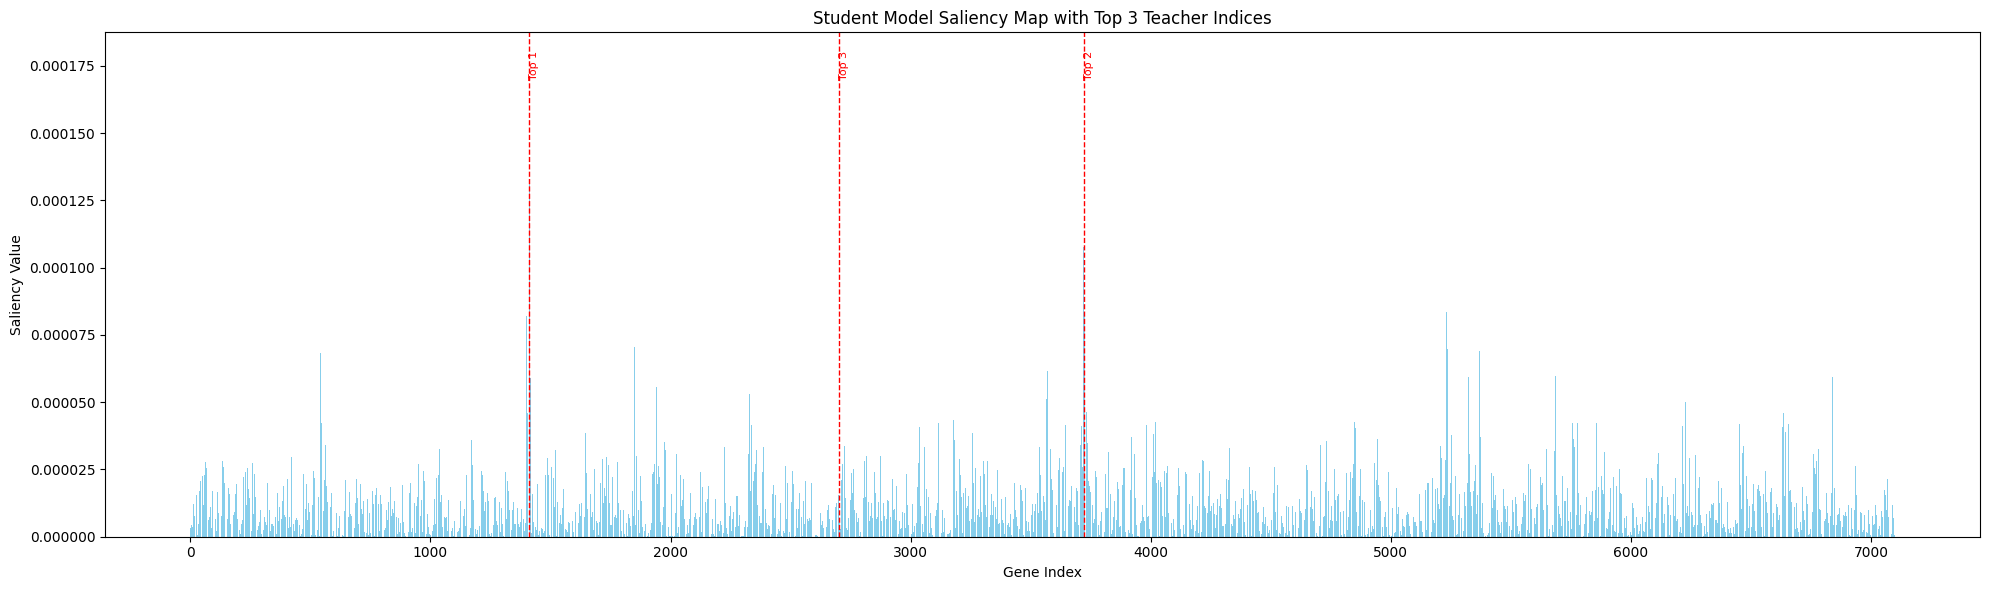

In [107]:
plot_saliency_with_teacher_top(student_saliency, teacher_top_indices)